# Gaussian Mixture Model

參考資料：[ML From Scratch, Part 5: Gaussian Mixture Models](http://www.oranlooney.com/post/ml-from-scratch-part-5-gmm/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
from prettytable import PrettyTable
# plt.style.use('seaborn')

## Load data

Image shape: (239, 320, 3)


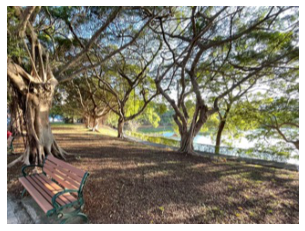

In [2]:
def load_image(data_path):
    img = Image.open(data_path)
    plt.axis('off')
    plt.imshow(img) # 看一下圖片原始的樣子
    img = np.asarray(img, dtype='float')
    return img

IMAGE_PATH = '/content/drive/MyDrive/ColabNotebooks/簡仁宗 深度學習+機器學習/ML_HW3/2020/dataset/imghw3.jpg'
img = load_image(IMAGE_PATH)
print(f'Image shape: {img.shape}')

## Preprocessing

In [3]:
def preprocessing(img):
    img = img.reshape(-1, 3)
    # [0, 255] -> [0, 1]
    img = img / 255.
    return img
    
X = preprocessing(img)
print(f'data shape: {X.shape}')

data shape: (76480, 3)


## K-means model

In [4]:
class KMeans:
    """ K-Meas
    1. definite distance
    2. initialize centroids
    3. update clusters (def create_centroids + def closest_centroids)
    4. update centroids (def get_centroids)
    """
    def __init__(self, k=5, max_iter=150, plot_steps=False):
        self.k = k
        self.max_iter = max_iter
        self.plot_steps = plot_steps

        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.k)]
        # mean feature vector for each cluster
        self.centroids = []
    
    # unsupervised learning dosen't need fit
    def predict(self, X):
        self.X = X
        self.sample_size, self.n_features = X.shape

        # initialize centroids(從樣本選出k個點當作起始的中心點)
        random_sample_idx = np.random.choice(self.sample_size, self.k, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idx]

        # optimization
        for num_iter in range(self.max_iter):
            # 更新 clusters
            self.clusters = self.create_clusters(self.centroids)
            if self.plot_steps:
                self.plot(num_iter)
            # 更新 centroids
            centroids_old = self.centroids # 舊的centroids
            self.centroids = self.get_centroids(self.clusters)
            if self.plot_steps:
                self.plot(num_iter)
            # 檢查是否收斂
            if self._check_convergence(centroids_old, self.centroids):
                break
        # 回傳 cluster labels
        return self.get_cluster_labels(self.clusters)
    
    def create_clusters(self, centroids):
        clusters = [[] for _ in range(self.k)]
        for idx, sample in enumerate(self.X):
            centrol_idx = self.closest_centroids(sample, centroids)
            clusters[centrol_idx].append(idx)
        return clusters
    
    def closest_centroids(self, sample, centroids):
        # 根據樣本計算它跟每一個centroids的距離
        distances = [self.euclidean_distance(sample, point) for point in centroids]
        closest_idx = np.argmin(distances)
        return closest_idx
    
    def get_centroids(self, clusters):
        centroids = np.zeros((self.k, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            clusters_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = clusters_mean
        return centroids
    
    def _check_convergence(self, centroids_old, centroids_new):
        distance = [self.euclidean_distance(centroids_old, point) for point in centroids_new]
        return distance == 0
    
    def get_cluster_labels(self, clusters):
        labels = np.empty(self.sample_size)
        for classes, group_idx in enumerate(clusters):
            for sample_idx in group_idx:
                labels[sample_idx] = classes
        return labels
    
    def plot(self, num_iter):
        fig, ax = plt.subplots(figsize=(12,8))

        for i, index in enumerate(self.clusters):
            point = self.X[index].T # flatten()
            ax.scatter(*point)
        
        for point in self.centroids:
            ax.scatter(*point, marker='x', color='black', linewidth=2)
        # plt.title(f'{num_iter} iterations for train')
        plt.show()

    @staticmethod
    def euclidean_distance(x1, x2):
        return np.sqrt(np.sum((x1 - x2)**2))

## Gaussian Mixture Model

In [5]:
class GaussianMixture:
    """Gaussian Mixture Model
    initial centrol using k-meas solution.
    """
    def __init__(self, k=3, max_iter=100):
        self.k = k
        self.max_iter = max_iter
        self.loglikelihood = []
        
    def init(self, X, parameters=None):
        self.X = X 
        self.sample_size, self.n_features = X.shape # (76480, 3)
        
        if parameters is not None:
            centroid, labels = parameters
            pi = [np.mean(labels == k) for k in range(self.k)] # (3, )
            mu = centroid # (3, 3)
            cov = [np.cov(X[np.where(labels==k)[0]].T) for k in range(self.k)] # (3, 3, 3)
        
        return np.array(pi), np.array(mu), np.array(cov)
    
    def EM(self, pi, mu, cov):
        
        # initialization
        self.pi, self.mu, self.cov = pi, mu, cov
        
        for n_iter in range(self.max_iter):
            # E step
            self._resp, self.likelihood = self._e_step(self.pi, self.mu, self.cov)
            # M step
            self.pi, self.mu, self.cov = self._m_step(self._resp)
            # recode log likelihood
            self.recode_likelihood(self.likelihood)
            
        return self.likelihood
            
    def _e_step(self, pi, mu, cov):
        likelihood = np.array([pi[k]*self.N(mu[k], cov[k]) for k in range(self.k)]) # (3, 76480)
        resp = np.array(likelihood / np.sum(likelihood, axis=0)).T # (76480, 3)
        return resp, likelihood
    
    def _m_step(self, resp):
        N_k = np.sum(resp, axis=0) # (3,)
        pi = N_k / self.sample_size # (3,)
        mu = np.dot(resp.T, self.X) /  N_k[:, np.newaxis] # (3, 3)
        cov = [ (1/N_k[k]) * np.dot((resp[:, k, np.newaxis]*(self.X - mu[k])).T, (self.X - mu[k]))  for k in range(self.k)]
        return pi, mu, cov
        
    def recode_likelihood(self, likelihood):
        # loglikelihood = np.mean(np.log(np.sum(likelihood, axis=0)))
        loglikelihood = np.sum(np.log(np.sum(likelihood, axis=0)))
        self.loglikelihood.append(loglikelihood)
    
    def N(self, mu, cov):
        return multivariate_normal.pdf(self.X, mu, cov)
    
    def plot_image(self, image, likelihood, save=False):
        high, width, color_shape = image.shape
        idx = np.argmax(likelihood, axis=0)
        img = (self.mu[idx]*255).astype(int)
        img = Image.fromarray(img.reshape(high, width, color_shape).astype('uint8'))
        plt.axis('off')
        plt.imshow(img)
        if save:
            img.save(f'GMM k={self.k}.png')

In [6]:
def Kplot_image(model, image, labels, ax=None, imshow=False, save=False, make_table=False):
    high, width, color_shape = image.shape
    label_idx = labels.astype(int)
    img = (model.centroids[label_idx]*255).astype(int)
    img = Image.fromarray(img.reshape(high, width, color_shape).astype('uint8'))
    if imshow:
        if ax is None:
            plt.axis('off')
            plt.title(f"{model.__class__.__name__} k = {model.k}")
            plt.imshow(img)
        else:
            axs[ax].axis('off')
            axs[ax].set_title(f"{model.__class__.__name__} k = {model.k}")
            axs[ax].imshow(img)
    if save:
        img.save(f'K-means k={model.k}.png')
    if make_table:
        table = PrettyTable()
        table.title = f'K-means k = {model.k}'
        table.add_column(f"{model.__class__.__name__}", [k for k in range(model.k)])
        table.add_column('R', [r for r in (model.centroids[:, 0]*255).astype(int)]) 
        table.add_column('G', [g for g in (model.centroids[:, 1]*255).astype(int)])
        table.add_column('B', [b for b in (model.centroids[:, 2]*255).astype(int)])
        print(table)


def Gplot_image(model, image, likelihood, ax=None, imshow=False, save=False, make_table=False):
    high, width, color_shape = image.shape
    idx = np.argmax(likelihood, axis=0)
    img = (model.mu[idx]*255).astype(int)
    img = Image.fromarray(img.reshape(high, width, color_shape).astype('uint8'))
    if imshow:
        if ax is None:
            plt.axis('off')
            plt.title(f"{model.__class__.__name__} k = {model.k}")
            plt.imshow(img)
        else:
            axs[ax].axis('off')
            axs[ax].set_title(f"{model.__class__.__name__} k = {model.k}")
            axs[ax].imshow(img)
    if save:
        img.save(f'GMM k={model.k}.png')
    if make_table:
        table = PrettyTable()
        table.title = f'GMM k = {model.k}'
        table.add_column(f"{model.__class__.__name__}", [k for k in range(model.k)])
        table.add_column('R', [r for r in (model.mu[:, 0]*255).astype(int)]) 
        table.add_column('G', [g for g in (model.mu[:, 1]*255).astype(int)])
        table.add_column('B', [b for b in (model.mu[:, 2]*255).astype(int)])
        print(table)

def plot_loglikelihood(model, ax=None):
    iter = np.arange(len(model.loglikelihood))
    if ax is None:
        plt.plot(iter+1, model.loglikelihood)
        plt.title(f'Log Likelihood k = {model.k}')
        plt.xlabel('Iterations')
        plt.ylabel('Log Likelihood')
        plt.show()
    else:
        axs[ax].plot(iter+1, model.loglikelihood)
        axs[ax].set_title(f'Log Likelihood k = {model.k}')
        axs[ax].set_xlabel('Iterations')
        axs[ax].set_ylabel('Log Likelihood')

## 3-1 Build K-means model and how the table of estimated $\{u_k\}_{k=1}^K$.

+--------------------------+
|      K-means k = 3       |
+--------+-----+-----+-----+
| KMeans |  R  |  G  |  B  |
+--------+-----+-----+-----+
|   0    | 169 | 167 | 150 |
|   1    | 107 |  99 |  79 |
|   2    |  63 |  56 |  44 |
+--------+-----+-----+-----+


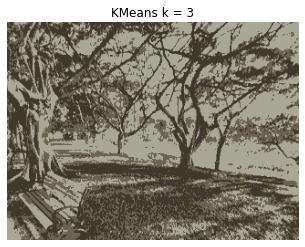

In [7]:
model_KMeans = KMeans(k=3, max_iter=2)
y_pred = model_KMeans.predict(X)
Kplot_image(model=model_KMeans, image=img, imshow=True, labels=y_pred, save=False, make_table=True)

## 3-2 Plot the log likelihood curve of GMM

Use $\{u_k\}_{k=1}^K$ calculated by the K-means model as means, and calculate the corresponding variances $\sigma^{2}_{k}$ and mixing coefficient $\pi_k$ for initialization of  $GMMp(x)=\sum^{K}_{k=1} \pi_kN(x|u_k,\sigma^{2}_{k})$.

Optimize the model by maximizing the log likelihood function $\log p(x|\pi, u, \sigma^2)$ through EM algorithm.

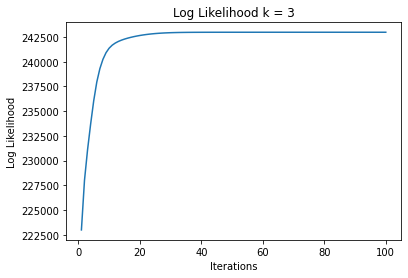

In [8]:
centroids = model_KMeans.centroids                  
model_GMM = GaussianMixture(k=3, max_iter=100)
pi, mu, cov = model_GMM.init(X, parameters=(centroids, y_pred))
likelihood = model_GMM.EM(pi, mu, cov)
plot_loglikelihood(model_GMM)

## 3-3 K = 3, 5, 7, 10

Repeat step (1) and (2) for K = 3, 5, 7, and 10.Please show the resulting images in your report

### K-means

+--------------------------+
|      K-means k = 3       |
+--------+-----+-----+-----+
| KMeans |  R  |  G  |  B  |
+--------+-----+-----+-----+
|   0    | 190 | 193 | 182 |
|   1    | 138 | 130 | 106 |
|   2    |  77 |  70 |  56 |
+--------+-----+-----+-----+
+--------------------------+
|      K-means k = 5       |
+--------+-----+-----+-----+
| KMeans |  R  |  G  |  B  |
+--------+-----+-----+-----+
|   0    | 174 | 179 | 173 |
|   1    | 108 | 100 |  81 |
|   2    | 223 | 222 | 206 |
|   3    |  66 |  59 |  46 |
|   4    | 148 | 141 | 117 |
+--------+-----+-----+-----+
+--------------------------+
|      K-means k = 7       |
+--------+-----+-----+-----+
| KMeans |  R  |  G  |  B  |
+--------+-----+-----+-----+
|   0    | 123 | 110 |  86 |
|   1    | 103 |  95 |  49 |
|   2    |  94 |  89 |  82 |
|   3    | 202 | 204 | 193 |
|   4    | 146 | 143 | 132 |
|   5    | 163 | 154 |  89 |
|   6    |  64 |  56 |  44 |
+--------+-----+-----+-----+
+--------------------------+
|      K-means

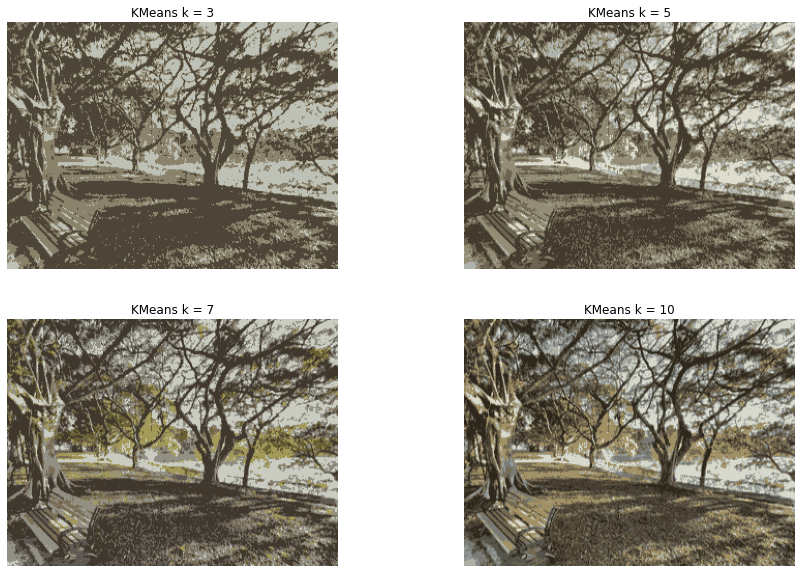

In [9]:
K = [3, 5, 7, 10]
fig, axs = plt.subplots(2, 2, figsize=(15,10))
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
for k, p in zip(K, positions):
    model_KMeans = KMeans(k=k, max_iter=2)
    y_pred = model_KMeans.predict(X)
    Kplot_image(model=model_KMeans, image=img, imshow=True, labels=y_pred, ax=p, save=False, make_table=True)
plt.show()

### GMM

+-----------------------------------+
|             GMM k = 3             |
+-----------------+-----+-----+-----+
| GaussianMixture |  R  |  G  |  B  |
+-----------------+-----+-----+-----+
|        0        | 153 | 159 | 138 |
|        1        | 108 |  96 |  78 |
|        2        |  74 |  62 |  55 |
+-----------------+-----+-----+-----+
+-----------------------------------+
|             GMM k = 5             |
+-----------------+-----+-----+-----+
| GaussianMixture |  R  |  G  |  B  |
+-----------------+-----+-----+-----+
|        0        | 160 | 165 | 165 |
|        1        | 126 | 110 |  85 |
|        2        | 141 | 151 | 111 |
|        3        |  79 |  65 |  58 |
|        4        |  74 |  70 |  59 |
+-----------------+-----+-----+-----+
+-----------------------------------+
|             GMM k = 7             |
+-----------------+-----+-----+-----+
| GaussianMixture |  R  |  G  |  B  |
+-----------------+-----+-----+-----+
|        0        | 157 | 169 | 169 |
|        1  

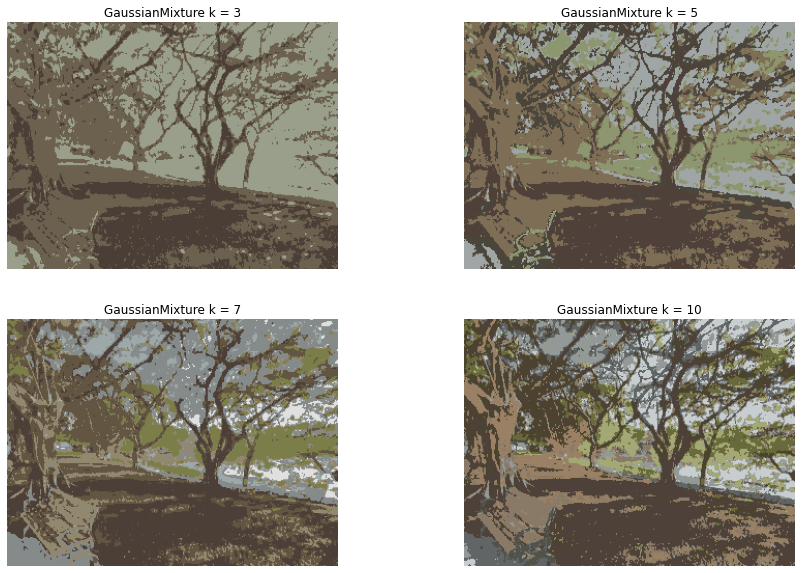

In [10]:
K = [3, 5, 7, 10]
fig, axs = plt.subplots(2, 2, figsize=(15,10))
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
for k, p in zip(K, positions):
    model_KMeans = KMeans(k=k, max_iter=2)
    y_pred = model_KMeans.predict(X)
    centroids = model_KMeans.centroids                  
    model_GMM = GaussianMixture(k=k, max_iter=100)
    pi, mu, cov = model_GMM.init(X, parameters=(centroids, y_pred))
    likelihood = model_GMM.EM(pi, mu, cov)
    Gplot_image(model_GMM, img, likelihood, ax=p, imshow=True, save=False, make_table=True)
plt.show()

## 3-4 Plot log likelihood with K = 3, 5, 7, 10

Please show the graph of Log likelihood at different iterations for K = 3, 5, 7, 10 respectively.

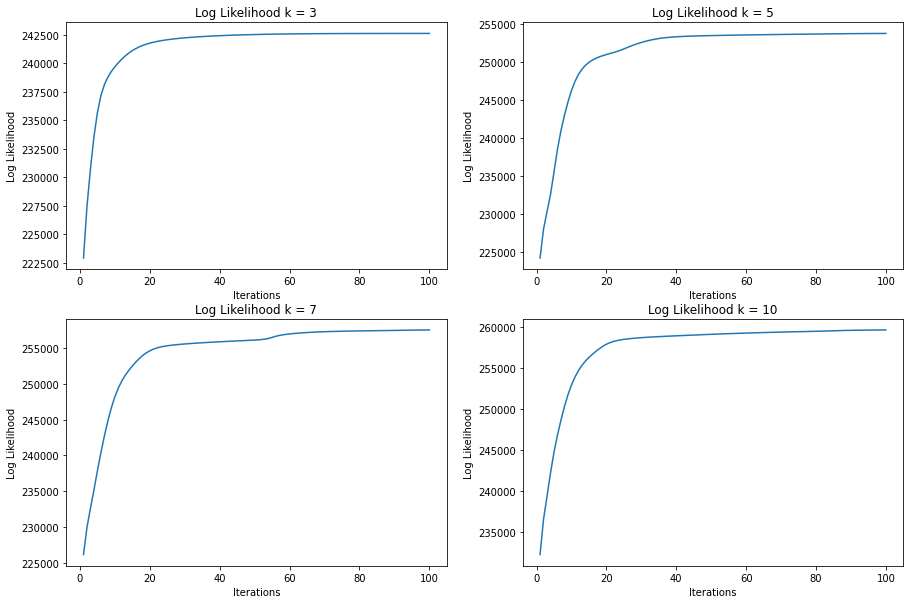

In [11]:
K = [3, 5, 7, 10]
fig, axs = plt.subplots(2, 2, figsize=(15,10))
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
for k, p in zip(K, positions):
    model_KMeans = KMeans(k=k, max_iter=2)
    y_pred = model_KMeans.predict(X)
    centroids = model_KMeans.centroids                  
    model_GMM = GaussianMixture(k=k, max_iter=100)
    pi, mu, cov = model_GMM.init(X, parameters=(centroids, y_pred))
    likelihood = model_GMM.EM(pi, mu, cov)
    plot_loglikelihood(model_GMM, p)
plt.show()